In [1]:
##
## Bunch of pre-reqs, do make sure they're all available
##
import pandas
import numpy
import math
import random
import datetime
import requests
import io
import zipfile
from dateutil.parser import parse
from scipy.interpolate import splrep, splev
from scipy.stats import zscore
from scipy.stats import norm
from scipy.stats import linregress
from scipy.stats import gamma
from scipy.stats import geom
import statsmodels.formula.api as smf
from lmfit import minimize, Parameters
# plotting with matplot
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

/home/markl/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
plt.rcParams['figure.figsize'] = [12, 9]

In [3]:
##
## ACTIVITIES 
##

In [4]:
## Read the remote zip file and the csv file zipped into it into a pandas dataframe
response = requests.get('https://s3.amazonaws.com/goldencheetah-opendata/datasets/activities.csv.zip')
zf = zipfile.ZipFile(io.BytesIO(response.content))
activities = pandas.read_csv(zf.open('activities.csv'))
##activities = pandas.read_csv('activities.csv')

In [5]:
len(activities[activities['sport'].isin(['Bike', 'Run', 'Swim'])])

555327

In [6]:
len(activities)

716267

In [7]:
len(set(activities["sport"]))

1384

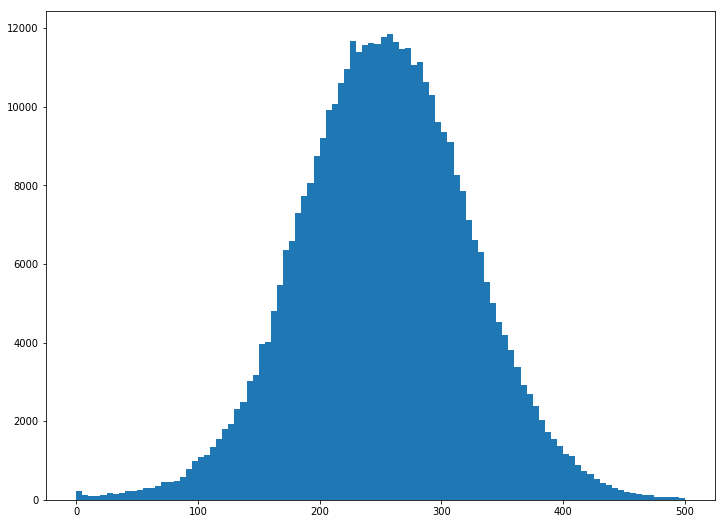

In [8]:
## hist of 3minute power across all workouts is normally distributed
p3=activities.loc[activities["3m_critical_power"]<1000]["3m_critical_power"]
plot = plt.subplot()
z=plot.hist(p3, 100, range=[0,500])

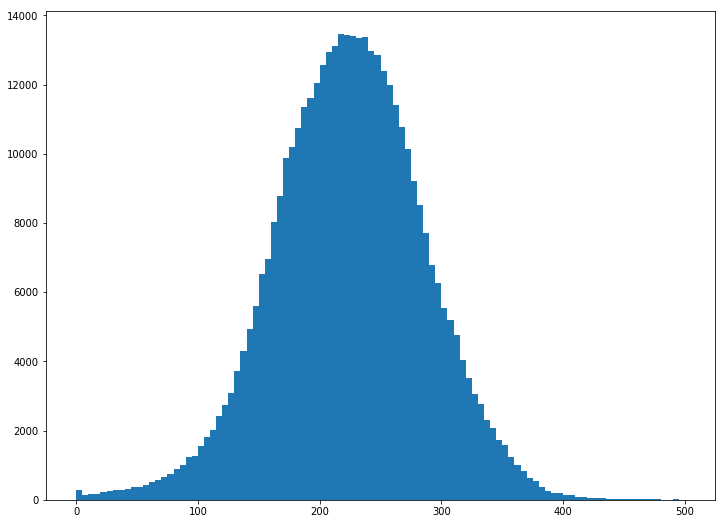

In [9]:
## hist of 8minute power across all workouts is normally distributed
p8=activities.loc[activities["8m_critical_power"]<1000]["8m_critical_power"]
plot = plt.subplot()
z=plot.hist(p8, 100, range=[0,500])

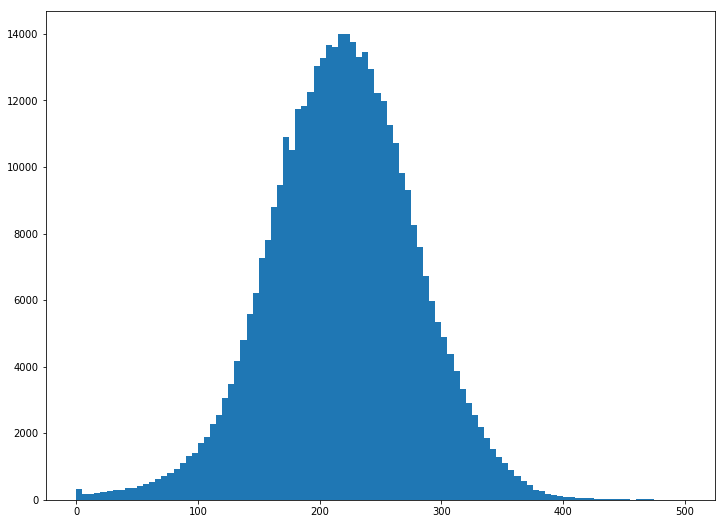

In [10]:
## hist of 10minute power across all workouts is normally distributed
p10=activities.loc[activities["10m_critical_power"]<1000]["10m_critical_power"]
plot = plt.subplot()
z=plot.hist(p10, 100, range=[0,500])

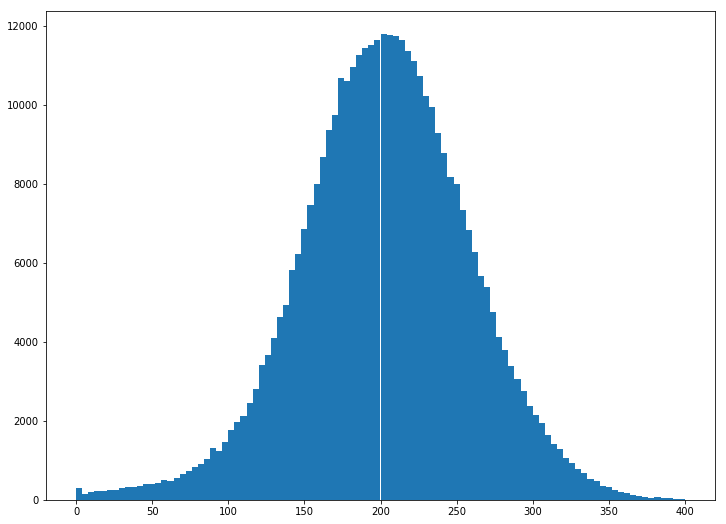

In [11]:
## hist of 20minute power across all workouts is normally distributed
p20=activities.loc[activities["20m_critical_power"]<1000]["20m_critical_power"]
plot = plt.subplot()
z=plot.hist(p20, 100, range=[0,400])

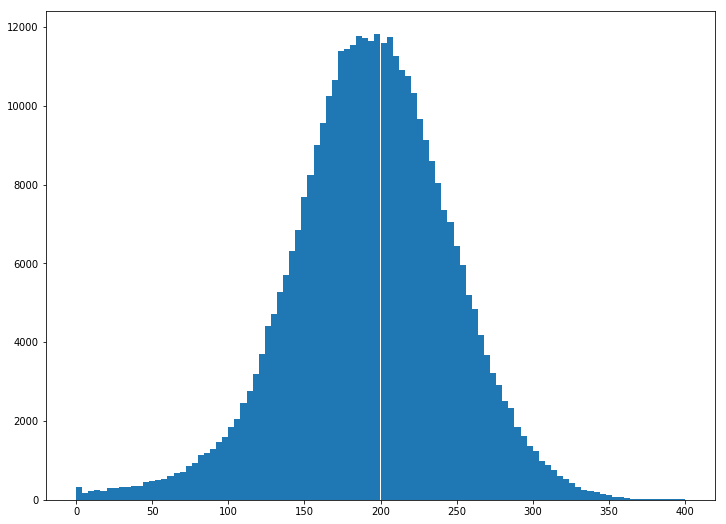

In [12]:
## hist of 30minute power across all workouts is normally distributed
p30=activities.loc[activities["30m_critical_power"]<1000]["30m_critical_power"]
plot = plt.subplot()
z=plot.hist(p30, 100, range=[0,400])

In [13]:
##
## ATHLETES
##

In [14]:
## Read the remote zip file and the csv file zipped into it into a pandas dataframe
response = requests.get('https://s3.amazonaws.com/goldencheetah-opendata/datasets/athletes.csv.zip')
zf = zipfile.ZipFile(io.BytesIO(response.content))
athletes = pandas.read_csv(zf.open('athletes.csv'))
##athletes=pandas.read_csv("athletes.csv", sep=",")
len(athletes)

1351

In [15]:
## CLEAN OUT WORST OF THE DATA PRIOR TO PROFILING POWER BASED DATA

In [16]:
# clean negative and low ages
athletes.loc[athletes['age']<=18,'age'] = 0
athletes.loc[athletes['age']>=100,'age'] = 0
len(athletes)

1351

In [17]:
# remove rows with data thats clearly invalid (super high values)
athletes =athletes.drop(athletes[athletes['1s_critical_power']>2500].index)
len(athletes)

1289

In [18]:
# remove rows with no power values
athletes =athletes.drop(athletes[(athletes['1s_critical_power']<=0) | (athletes['1s_critical_power']==1000)| (athletes['1s_critical_power']==2000)].index)
len(athletes)

1141

In [19]:
# remove rows with no long duration power values
athletes =athletes.drop(athletes[athletes['20m_critical_power']<=0].index)
len(athletes)

1137

In [20]:
# remove rows with data thats clearly invalid (super high values)
athletes =athletes.drop(athletes[athletes['3m_critical_power']>800].index)
len(athletes)

1121

In [21]:
# remove rows with oob wpk for 5min power (bad weight data?)
athletes =athletes.drop(athletes[athletes['5m_peak_wpk']>10].index)
len(athletes)

1105

In [22]:
# remove rows with 4min power > 600w as totally insane, would set new WR for the pursuit
athletes =athletes.drop(athletes[athletes['240s_peak']>600].index)
len(athletes)

1091

In [23]:
# classic cp
def cpw(df):
    x=[ 3*60, 8*60, 10*60, 20*60 ]
    y=[ 0, 0, 0, 0]
    y[0]=df["3m_critical_power"] * x[0]
    y[1]=df["8m_critical_power"] * x[1]
    y[2]=df["10m_critical_power"] * x[2]
    y[3]=df["20m_critical_power"] * x[3]
 
    cp,w,r,p,s=linregress(x,y)
    return cp

# classic w'
def w(df):
    x=[ 3*60, 8*60, 10*60, 20*60 ]
    y=[ 0, 0, 0, 0]
    y[0]=df["3m_critical_power"] * x[0]
    y[1]=df["8m_critical_power"] * x[1]
    y[2]=df["10m_critical_power"] * x[2]
    y[3]=df["20m_critical_power"] * x[3]
 
    cp,w,r,p,s=linregress(x,y)
    return w

# fit
def r2(df):
    x=[ 3*60, 8*60, 10*60, 20*60 ]
    y=[ 0, 0, 0, 0]
    y[0]=df["3m_critical_power"] * x[0]
    y[1]=df["8m_critical_power"] * x[1]
    y[2]=df["10m_critical_power"] * x[2]
    y[3]=df["20m_critical_power"] * x[3]
 
    cp,w,r,p,s=linregress(x,y)
    return r

In [24]:
# morton resids
def residual(params, x, data):
    cp = params['cp']
    w = params['w']
    k = params['k']
    model = cp + (w/(x+k))
    return (data-model)

## pmax from morton model
def pmax2(df):
    params = Parameters()
    params.add('cp', value=250)
    params.add('w', value=18000)
    params.add('k', value=32)

    # x and y
    x = [15,20,60,180,420,720]
    y = [df['15s_critical_power'],df['20s_peak'],df['60s_peak'],df['180s_peak'],df['420s_peak'],df['720s_peak']] 
    out = minimize(residual, params, args=(x, y))
    return out.params['cp']+(out.params['w']/(1+out.params['k'].value))

## pmax direct from data
def pmax(df):
    return df['1s_critical_power']

In [25]:
## add various estimates using 2 and 3 parameter models
## note CP and W' from Classic CP Pmax from data Pmax2 from Morton
## it would be faster to apply all paramaters at once (we do this later with mmp data)
## but this code is just for example -- you are free to modify it
athletes['CP'] = athletes.apply(lambda row: cpw(row), axis=1)
athletes['W'] = athletes.apply(lambda row: w(row), axis=1)
athletes['Pmax'] = athletes.apply(lambda row: pmax(row), axis=1)
athletes['Pmax2']=athletes.apply(lambda row: pmax2(row), axis=1)
athletes['R2'] = athletes.apply(lambda row: r2(row), axis=1)

## add wpk vales for CP, W' and Pmax
athletes['CP WPK']=athletes['CP']/athletes['weightkg']
athletes['W WPK']=athletes['W']/athletes['weightkg']
athletes['Pmax WPK']=athletes['Pmax']/athletes['weightkg']

In [26]:
athletes["R2"].mean(), athletes["R2"].mode(), athletes["R2"].max() 

(0.9985173748575593, 0    0.999735
 1    0.999987
 dtype: float64, 0.9999998962247436)

In [27]:
# remove dodgy W' data
athletes =athletes.drop(athletes[athletes['W']<1000].index)
athletes =athletes.drop(athletes[athletes['W']>40000].index)
len(athletes)

1040

In [28]:
# remove dodgy CP data
athletes =athletes.drop(athletes[athletes['CP']<100].index)
athletes =athletes.drop(athletes[athletes['CP']>450].index)
len(athletes)

1026

In [29]:
## get rid of dodgy pmax data
athletes =athletes.drop(athletes[athletes['Pmax2']>2500].index)
athletes =athletes.drop(athletes[athletes['Pmax2']<0].index)
athletes =athletes.drop(athletes[athletes['Pmax']>2500].index)
len(athletes)

938

In [30]:
athletes["R2"].mean(), athletes["R2"].mode(), athletes["R2"].max() 

(0.9992275054386988, 0    0.999735
 1    0.999987
 dtype: float64, 0.9999998962247436)

In [31]:
athletes["EI"]=athletes["W"]/athletes["CP"]

Text(71.1945798482377, 0, '71.194')

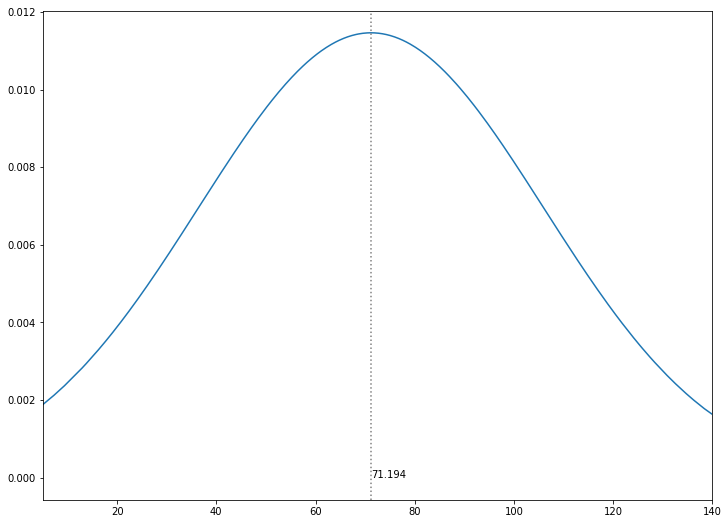

In [32]:
#endurance index distrobution
data = athletes[athletes['EI']>0]['EI']
h = data.sort_values()
pdf = norm.pdf(h, h.mean(), h.std())
plot = plt.subplot()
plot.set_xlim(5,140)
z=plot.plot(h, pdf)
plot.axvline(h.mean(), linestyle=':', color='grey') # horizontal lines
plt.text(0.001+h.mean(),0, str(round(h.mean(),3)))

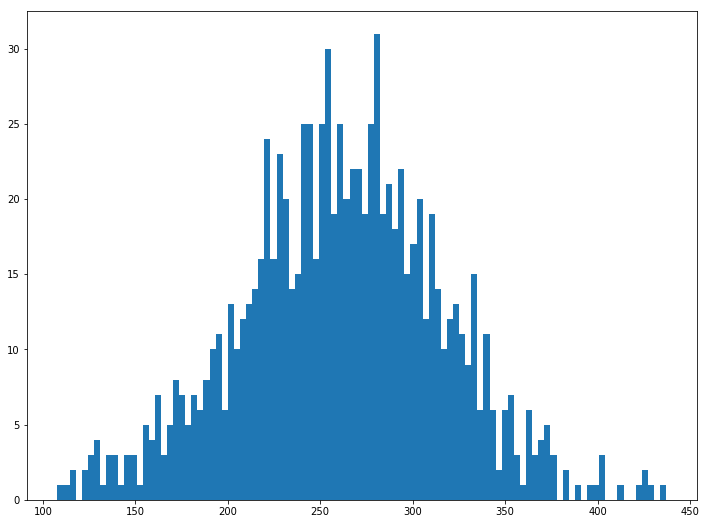

In [33]:
plot = plt.subplot()
z=plot.hist(athletes['CP'], 100)

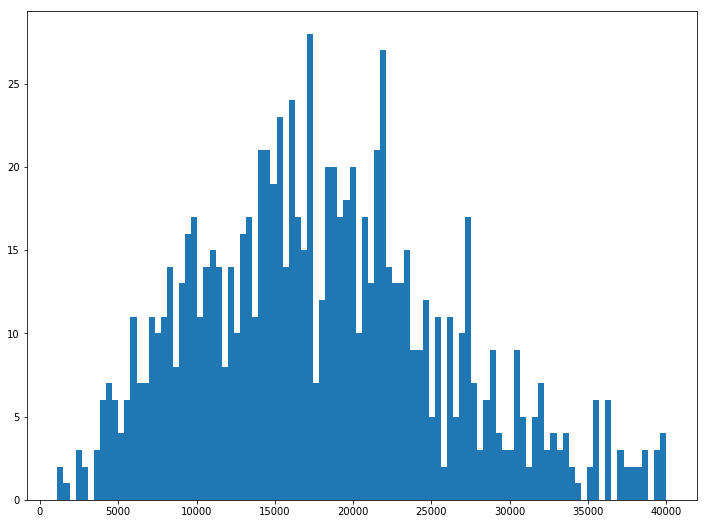

In [34]:
plot = plt.subplot()
z=plot.hist(athletes.loc[(athletes['W']>1000) & (athletes['W']<40000)]['W'], 100)

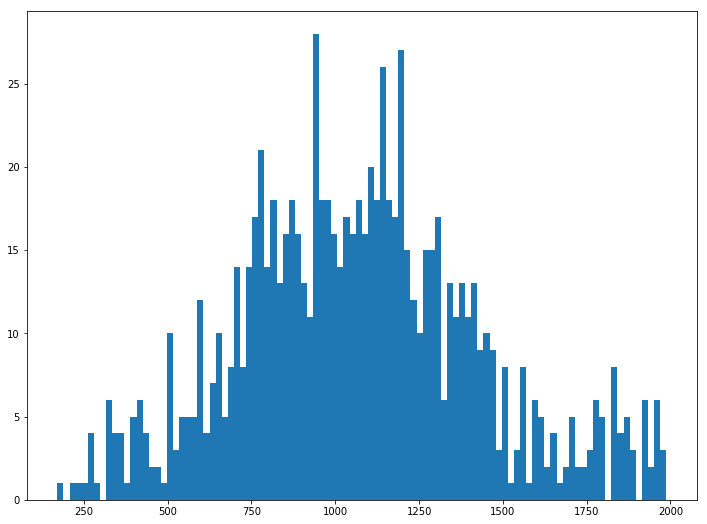

In [35]:
plot = plt.subplot()
z=plot.hist(athletes.loc[(athletes['Pmax']>100) & (athletes['Pmax']<2000)]['Pmax'], 100)

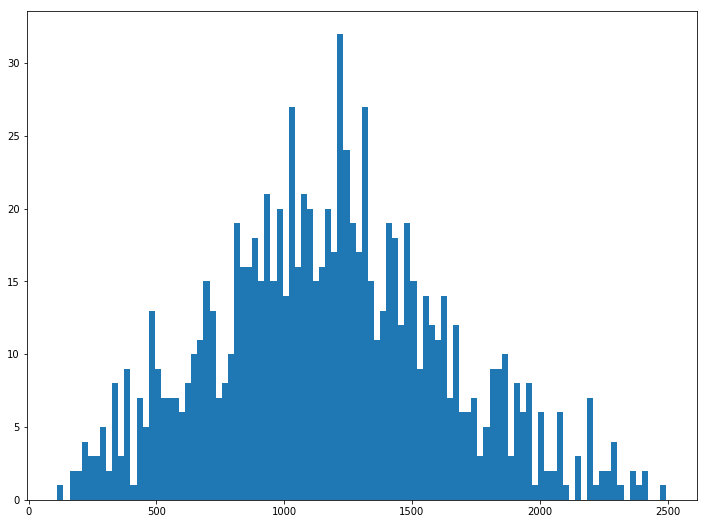

In [36]:
plot = plt.subplot()
z=plot.hist(athletes.loc[(athletes['Pmax2']>100) & (athletes['Pmax2']<2500)]['Pmax2'], 100)

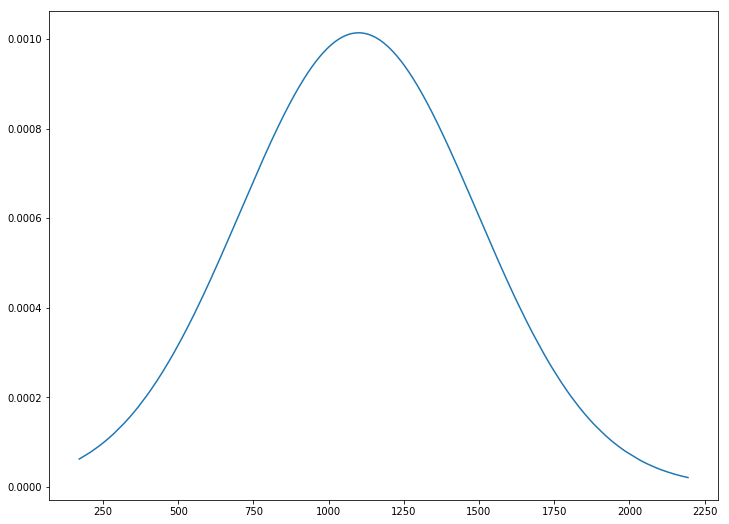

In [37]:
data = athletes.loc[(athletes['Pmax']>0) & (athletes['Pmax']<2200)]['Pmax']
h = data.sort_values()
pdf = norm.pdf(h, h.mean(), h.std())
plot = plt.subplot()
z=plot.plot(h, pdf)

In [38]:
h.mean(),h.std()

(1099.8305589834254, 393.26964415612076)

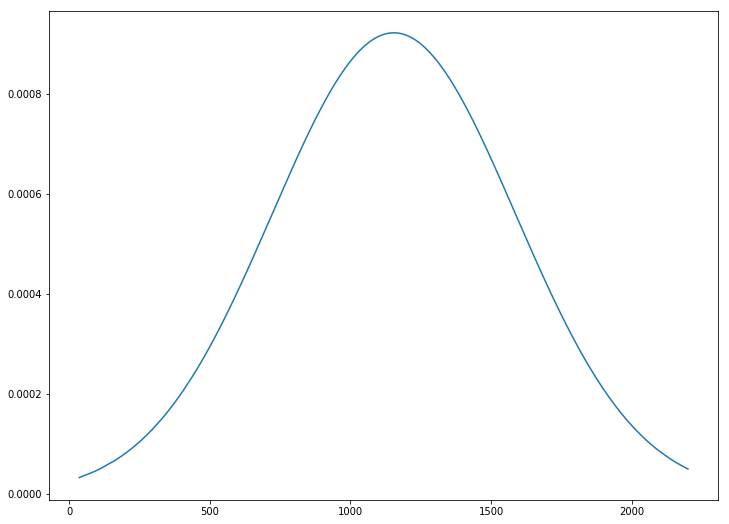

In [39]:
data = athletes.loc[(athletes['Pmax2']>0) & (athletes['Pmax2']<2200)]['Pmax2']
h = data.sort_values()
pdf = norm.pdf(h, h.mean(), h.std())
plot = plt.subplot()
z=plot.plot(h, pdf)

In [40]:
h.mean(),h.std()

(1154.0281079735519, 432.83848999652884)

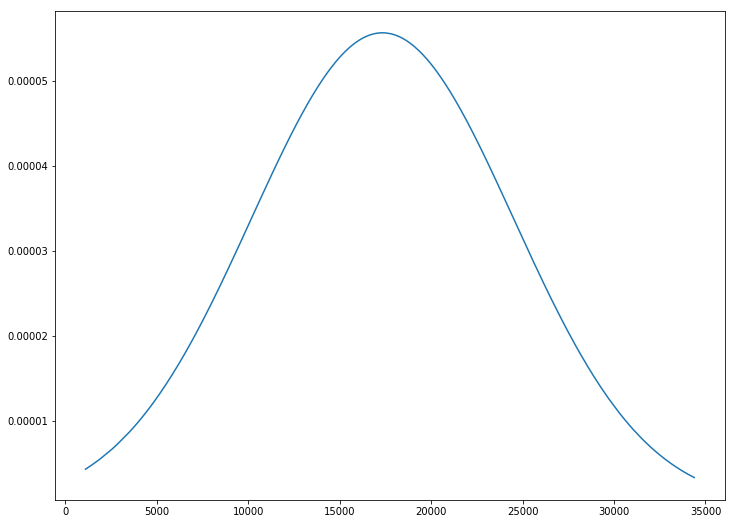

In [41]:
data = athletes.loc[(athletes['W']>1000) & (athletes['W']<35000)]['W']
h = data.sort_values()
pdf = norm.pdf(h, h.mean(), h.std())
plot = plt.subplot()
z=plot.plot(h, pdf)

In [42]:
h.mean(), h.std()

(17344.774324138492, 7173.07280910612)

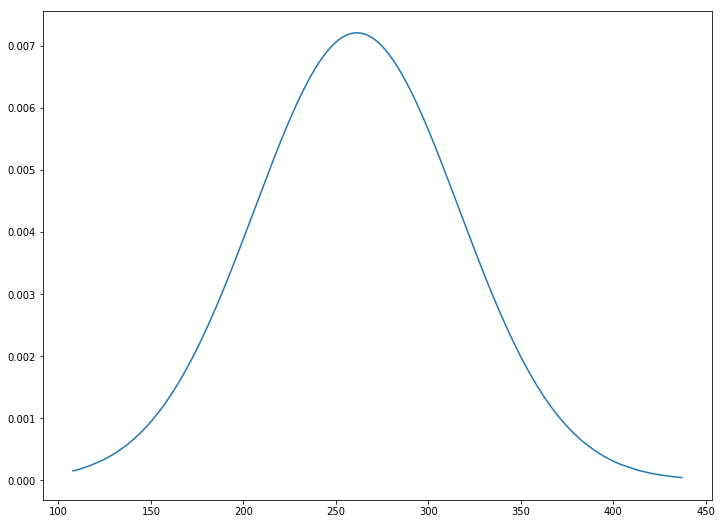

In [43]:
data = athletes['CP']
h = data.sort_values()
pdf = norm.pdf(h, h.mean(), h.std())
plot = plt.subplot()
z=plot.plot(h, pdf)

In [44]:
h.mean(), h.std()

(261.40015984101007, 55.272274112730614)

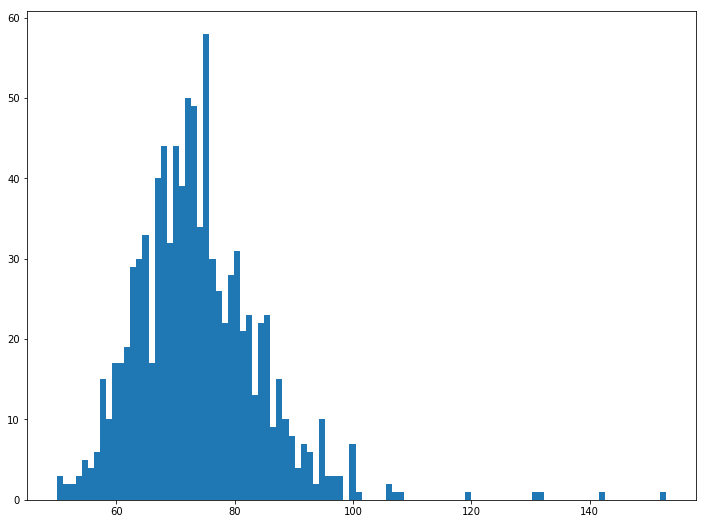

In [45]:
plot = plt.subplot()
z=plot.hist(athletes['weightkg'], 100)

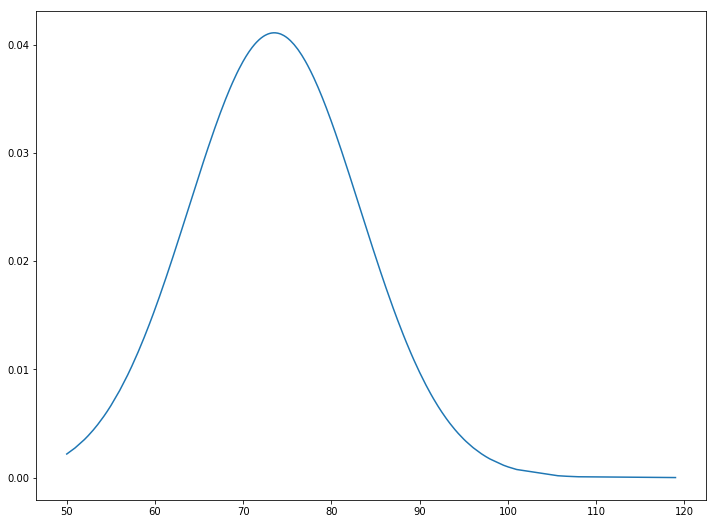

In [46]:
data = athletes.loc[(athletes['weightkg']>0) & (athletes['weightkg']<120)]['weightkg']
h = data.sort_values()
pdf = norm.pdf(h, h.mean(), h.std())
plot = plt.subplot()
z=plot.plot(h, pdf)

In [47]:
h.mean(), h.std(), h.mode()

(73.52125298287119, 9.702523201560984, 0    75.0
 dtype: float64)

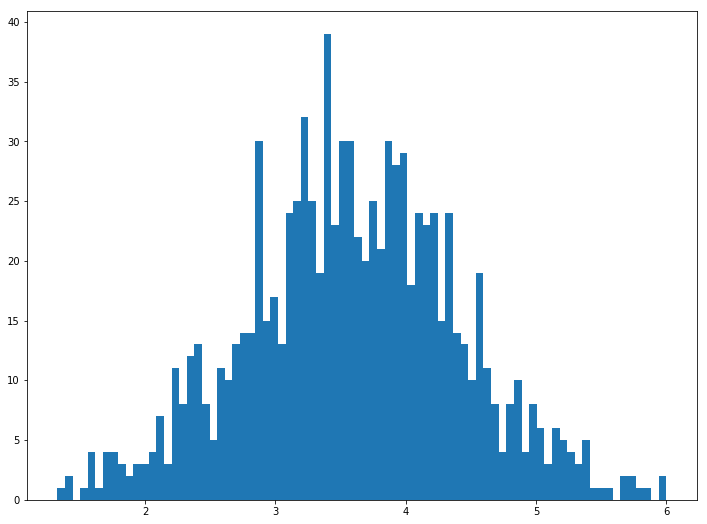

In [48]:
plot = plt.subplot()
z=plot.hist(athletes['CP WPK'], 80)

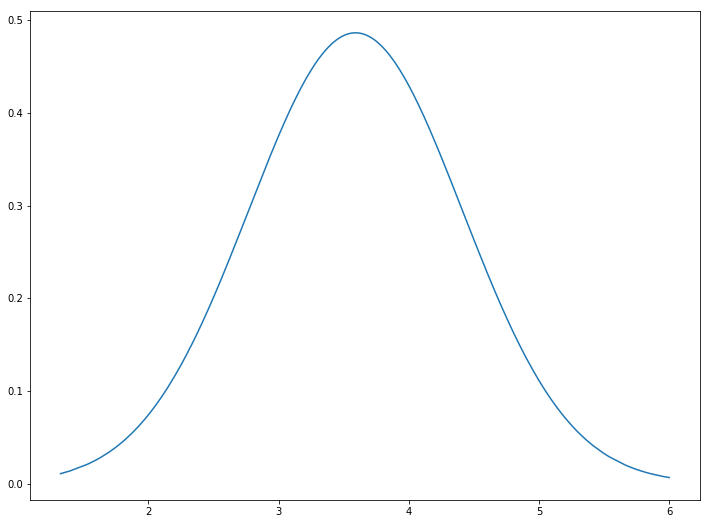

In [49]:
#data = athletes.loc[(athletes['weightkg']>0) & (athletes['weightkg']<150)]['weightkg']
data = athletes['CP WPK']
h = data.sort_values()
pdf = norm.pdf(h, h.mean(), h.std())
plot = plt.subplot()
z=plot.plot(h, pdf)

In [50]:
h.mean(), h.std(), h.mode()

(3.5909208728792166, 0.8199087217524923, 0    4.559225
 dtype: float64)

In [51]:
h.mean() + (3.4*h.std())

6.37861052683769

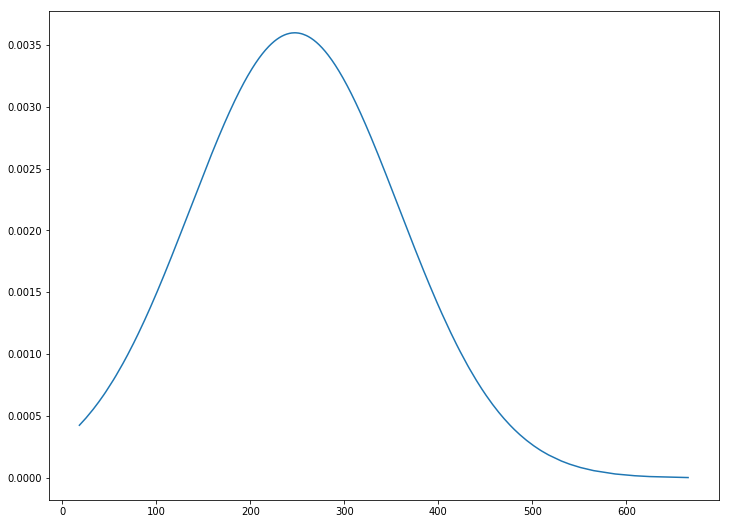

In [52]:
#data = athletes.loc[(athletes['weightkg']>0) & (athletes['weightkg']<150)]['weightkg']
data = athletes['W WPK']
h = data.sort_values()
pdf = norm.pdf(h, h.mean(), h.std())
plot = plt.subplot()
z=plot.plot(h, pdf)

In [53]:
h.mean(), h.std(), h.mode()

(247.1376571888446, 110.90715839457128, 0    203.529258
 dtype: float64)

In [54]:
# lets write as a csv -- this is the data you find on the powerprofile xls data sheet
athletes.to_csv('powerprofile.csv', sep=',')

In [55]:
qs=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.9999]
qs=sorted(qs,reverse=True) ## if you want it that way
athletes.quantile(qs)

,age,activities,bike,run,swim,other,1s_critical_power,15s_critical_power,2m_critical_power,3m_critical_power,...,weightstd,CP,W,Pmax,Pmax2,R2,CP WPK,W WPK,Pmax WPK,EI
0.9999,85.2504,9876.7885,3881.0499,1373.3134,1204.8916,9744.6392,2488.926914,2433.452032,662.794769,593.322555,...,2.182423e+03,436.476717,39993.370592,2488.926914,2487.673419,1.000000,5.994899,665.656195,39.445658,301.515382
0.9000,55.0000,1128.0000,798.9000,159.0000,20.0000,297.3000,1810.700000,1011.886670,495.193573,446.172222,...,1.582099e+00,329.756502,28817.498362,1810.700000,1813.412865,0.999980,4.607855,395.481843,24.489712,113.659888
0.8000,50.0000,762.2000,536.6000,52.6000,1.0000,129.4000,1426.000000,938.064572,448.003330,412.685556,...,8.976148e-01,306.330153,24361.756009,1426.000000,1555.504299,0.999944,4.261804,340.243565,19.818818,94.936693
0.7000,46.9000,579.0000,375.7000,12.0000,0.0000,61.9000,1287.900000,871.513330,424.405000,389.191115,...,4.217615e-01,289.340708,21790.102535,1287.900000,1403.900618,0.999904,4.009242,299.923819,17.614735,83.177542
0.6000,43.0000,441.4000,278.0000,3.0000,0.0000,28.0000,1178.000000,817.333330,402.620000,372.017782,...,8.624686e-02,276.759863,19605.626581,1178.000000,1273.984564,0.999847,3.811550,265.046496,16.025195,73.820751
0.5000,39.0000,317.5000,206.0000,1.0000,0.0000,13.0000,1093.000000,758.433335,382.912500,353.867205,...,1.421603e-14,261.897873,17299.356516,1093.000000,1170.081597,0.999767,3.569185,237.239993,14.780657,67.284704
0.4000,36.0000,234.0000,139.8000,0.0000,0.0000,5.0000,988.200000,706.973336,363.670000,337.239998,...,0.000000e+00,248.999288,15458.313180,988.200000,1050.133710,0.999658,3.390784,211.023803,13.524929,60.776911
0.3000,31.0000,173.0000,88.0000,0.0000,0.0000,2.0000,893.100000,645.846670,338.006664,312.172781,...,0.000000e+00,233.067181,13460.468422,893.100000,936.585169,0.999455,3.189601,178.993704,12.286411,50.927725
0.2000,23.0000,92.0000,43.0000,0.0000,0.0000,0.0000,788.000000,564.033330,310.675000,289.248892,...,0.000000e+00,217.725853,10780.883774,788.000000,803.607794,0.999095,2.892818,147.967013,10.747720,43.235599
0.1000,0.0000,34.0000,12.0000,0.0000,0.0000,0.0000,641.004900,451.160000,274.930830,255.541840,...,0.000000e+00,190.403488,8010.005567,641.004900,566.335161,0.998331,2.502967,108.461668,8.646178,31.034101


In [56]:
##
## MMP
##

In [57]:
## Read the remote zip file and the csv file zipped into it into a pandas dataframe
response = requests.get('https://s3.amazonaws.com/goldencheetah-opendata/datasets/activities_mmp.csv.zip')
zf = zipfile.ZipFile(io.BytesIO(response.content))
mmps = pandas.read_csv(zf.open('activities_mmp.csv'))
##mmps = pandas.read_csv('activities_mmp.csv')

In [58]:
mmps.head()

,id,date,weight,duration,distance,average_power,1,2,3,4,...,7200,10800,14400,18000,21600,25200,28800,32400,36000,Unnamed: 104
0,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/09/28 11:27:23 UTC,67.0,9413.0,65.7376,158.26414,681,635.0,607.0,583.0,...,160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/01 13:36:48 UTC,67.0,10533.0,73.7089,143.79754,509,498.0,492.0,488.0,...,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/03 07:55:37 UTC,67.0,5153.0,29.8093,145.71071,459,444.0,430.0,423.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/04 12:56:32 UTC,67.0,10814.0,80.7776,139.96787,666,650.0,615.0,583.0,...,151.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/06 13:30:40 UTC,67.0,6337.0,55.5281,148.35222,646,629.0,603.0,567.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# remove known problems .. these two indicate virtual power algorithms
mmps =mmps.drop(mmps[mmps['1']==2000].index)
mmps =mmps.drop(mmps[mmps['1']==1000].index)

# remove values outside the 99% percentile
mmps =mmps.drop(mmps[mmps['1']>2452].index)
mmps =mmps.drop(mmps[mmps['180']>516].index)
mmps =mmps.drop(mmps[mmps['420']>453].index)
mmps =mmps.drop(mmps[mmps['720']>438].index)
mmps =mmps.drop(mmps[mmps['1200']>414].index)

# remove spikey data
mmps =mmps.drop(mmps[mmps['1']>(mmps['5']*1.3)].index)
mmps =mmps.drop(mmps[mmps['1']>(mmps['2']*1.2)].index)
mmps =mmps.drop(mmps[mmps['1']==mmps['2']].index)

# no weight available
mmps =mmps.drop(mmps[mmps['weight']<=0].index)
len(mmps)

304028

In [60]:
# add month and year column
def year(df):
    return parse(df['date']).year
def month(df):
    return parse(df['date']).month

##mmps['month'] = mmps.apply(lambda row: month(row), axis=1)
mmps['year'] = mmps.apply(lambda row: year(row), axis=1)

In [61]:
# create a watts per kilo version before aggregating
mmwpk = mmps.copy()
mmps.head()

,id,date,weight,duration,distance,average_power,1,2,3,4,...,10800,14400,18000,21600,25200,28800,32400,36000,Unnamed: 104,year
0,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/09/28 11:27:23 UTC,67.0,9413.0,65.7376,158.26414,681,635.0,607.0,583.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
1,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/01 13:36:48 UTC,67.0,10533.0,73.7089,143.79754,509,498.0,492.0,488.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/03 07:55:37 UTC,67.0,5153.0,29.8093,145.71071,459,444.0,430.0,423.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
3,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/04 12:56:32 UTC,67.0,10814.0,80.7776,139.96787,666,650.0,615.0,583.0,...,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/06 13:30:40 UTC,67.0,6337.0,55.5281,148.35222,646,629.0,603.0,567.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


In [62]:
mmwpk.columns[2], mmwpk.columns[6]

('weight', '1')

In [63]:
# convert to wpk in mmwpk
for idx in range (6,len(mmwpk.columns)-2):
    name=mmwpk.columns[idx]
    mmwpk[name]=mmwpk[name]/mmwpk["weight"]

In [64]:
mmwpk.head()

,id,date,weight,duration,distance,average_power,1,2,3,4,...,10800,14400,18000,21600,25200,28800,32400,36000,Unnamed: 104,year
0,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/09/28 11:27:23 UTC,67.0,9413.0,65.7376,158.26414,10.164179,9.477612,9.059701,8.701493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
1,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/01 13:36:48 UTC,67.0,10533.0,73.7089,143.79754,7.597015,7.432836,7.343284,7.283582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/03 07:55:37 UTC,67.0,5153.0,29.8093,145.71071,6.850746,6.626866,6.417910,6.313433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
3,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/04 12:56:32 UTC,67.0,10814.0,80.7776,139.96787,9.940299,9.701493,9.179104,8.701493,...,2.014925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
4,9bdd724b-4148-4bee-9344-9e7a526c7fc1,2018/10/06 13:30:40 UTC,67.0,6337.0,55.5281,148.35222,9.641791,9.388060,9.000000,8.462687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


In [65]:
# aggregate year and monthly bests - will take a while !
athlete_years = mmps.groupby(['id','year'], as_index=False).max()
athlete_years_count = mmps.groupby(['id','year'], as_index=False).count()
athlete_years['count'] = athlete_years_count['1']
##athlete_months = mmps.groupby(['id','year', 'month'], as_index=False).max()

In [66]:
athlete_years_sum = mmwpk.groupby(['id','year'], as_index=False).sum()
athlete_years['distance'] = athlete_years_sum['distance']
athlete_years['duration'] = athlete_years_sum['duration']

In [67]:
athlete_years.head()

,id,year,date,weight,duration,distance,average_power,1,2,3,...,10800,14400,18000,21600,25200,28800,32400,36000,Unnamed: 104,count
0,000c6417-e1e4-497e-89e6-bb21e17ec355,2017,2017/12/31 08:02:19 UTC,71.0,1304560.0,9132.26161,278.05994,1186,1096.0,1084.0,...,238.0,216.0,188.0,185.0,NaN,NaN,NaN,NaN,NaN,117
1,000c6417-e1e4-497e-89e6-bb21e17ec355,2018,2018/11/11 07:38:03 UTC,71.0,2117532.0,14837.33016,322.40127,1250,1244.0,1216.0,...,281.0,272.0,204.0,204.0,187.0,152.0,NaN,NaN,NaN,194
2,0031326c-e796-4f35-8f25-d3937edca90f,2016,2016/12/31 07:44:41 UTC,81.0,36409.0,196.08380,166.89544,645,626.0,595.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3,0031326c-e796-4f35-8f25-d3937edca90f,2017,2017/12/31 20:11:44 UTC,81.0,389755.0,2039.55773,419.90909,1011,980.0,970.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121
4,0031326c-e796-4f35-8f25-d3937edca90f,2018,2018/04/03 07:18:03 UTC,81.0,178739.0,961.07693,214.00078,1145,1120.0,1100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63


In [68]:
# aggregate year and monthly bests - will take a while !
athlete_years_wpk = mmwpk.groupby(['id','year'], as_index=False).max()
athlete_years_count_wpk = mmwpk.groupby(['id','year'], as_index=False).count()
athlete_years_wpk['count'] = athlete_years_count_wpk['1']
##athlete_months = mmps.groupby(['id','year', 'month'], as_index=False).max()

In [69]:
athlete_years_sum_wpk = mmwpk.groupby(['id','year'], as_index=False).sum()
athlete_years_wpk['distance'] = athlete_years_sum_wpk['distance']
athlete_years_wpk['duration'] = athlete_years_sum_wpk['duration']

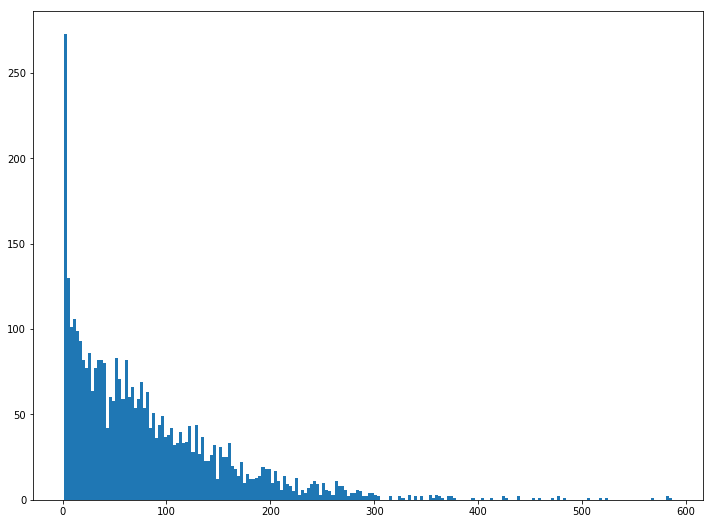

In [70]:
plot = plt.subplot()
z=plot.hist(athlete_years_wpk['count'], 200)

In [71]:
len(athlete_years), len(athlete_years_wpk)

(3725, 3725)

In [72]:
# lets write as a csv
##athlete_months.to_csv('/home/markl/opendata-analysis/athletemonths_mmp.csv', sep=',')

In [73]:
# lets write as a csv
##athlete_years.to_csv('/home/markl/opendata-analysis/athleteyears_mmp.csv', sep=',')

In [74]:
## use 3,7,12 to estimate CP and W'
def cp3res(params, x, data):
    cp = params['cp']
    w = params['w']
    k = params['k']
    model = cp + (w/(x+k))
    return (data-model)

def cp3(df):
    params = Parameters()
    params.add('cp', value=250)
    params.add('w', value=18000)
    params.add('k', value=32)

    # x and y
    x = [15,20,60,180,420,720]
    y = [df['15'],df['20'],df['60'],df['180'],df['420'],df['720']] 
    if (math.isfinite(y[0]) and math.isfinite(y[1]) and math.isfinite(y[2]) and math.isfinite(y[3]) and math.isfinite(y[4]) and math.isfinite(y[5])):
        out = minimize(cp3res, params, args=(x, y))
        return out.params['cp'].value, out.params['w'].value, out.params['cp'].value+(out.params['w'].value/(1+out.params['k'].value))
    return 0,0,0

In [75]:
# get estimates in a tuple
athlete_years['est']=athlete_years.apply(lambda row: cp3(row), axis=1)

In [76]:
athlete_years[['cp','w','pmax']] =athlete_years['est'].apply(pandas.Series)

In [77]:
## clean up a bit
athlete_years =athlete_years.drop(['est'], axis=1)

In [78]:
#clean out dodgy w' cp and pmax values
# remove dodgy W' values
athlete_years =athlete_years.drop(athlete_years[athlete_years['w']<1000].index)
athlete_years =athlete_years.drop(athlete_years[athlete_years['w']>35000].index)

# remove dodgy CP values
athlete_years =athlete_years.drop(athlete_years[athlete_years['cp']<100].index)
athlete_years =athlete_years.drop(athlete_years[athlete_years['cp']>400].index)

## get rid of dodgy pmax values
athlete_years =athlete_years.drop(athlete_years[athlete_years['pmax']>2450].index)
athlete_years =athlete_years.drop(athlete_years[athlete_years['pmax']<0].index)

# how many now?
len(athlete_years)

3100

In [79]:
athlete_years['cpratio'] = athlete_years['cp'] / athlete_years['1200']

Text(0.9734610980012207, 5, '0.972')

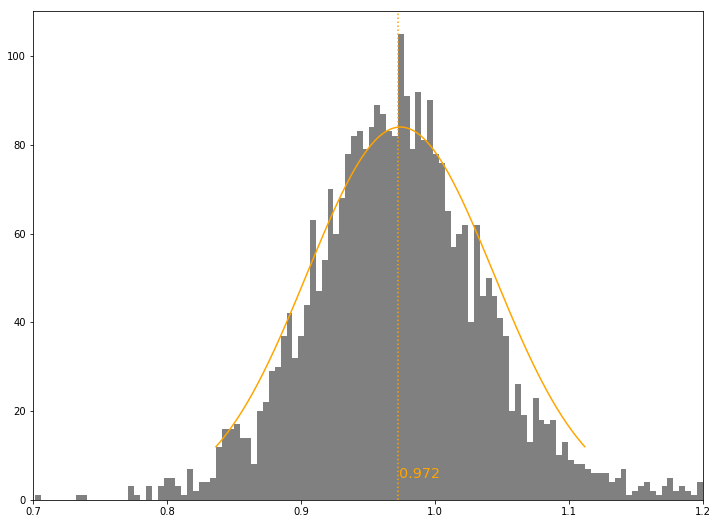

In [80]:
plot = plt.subplot()
plot.set_xlim(0.7,1.2)
data2 = athlete_years.loc[athlete_years['cpratio']>0]['cpratio']
h2 = data2.sort_values()
pdf2 = norm.pdf(h2, h2.mean(), h2.std())

y2, _, _ = plot.hist(h2,255,color='grey')
factor= y2.max()/pdf2.max()*0.8
z2=plot.plot(h2[pdf2>0.8], pdf2[pdf2>0.8]*factor, color='orange')
plot.axvline(h2.median(), linestyle=':', color='orange') # horizontal lines
plt.text(0.001+h2.median(),5, str(round(h2.median(),3)), color='orange', size='x-large')

In [81]:
athlete_years['cp'].quantile([0.10,0.5,0.90])

0.1    185.024980
0.5    257.225851
0.9    328.612953
Name: cp, dtype: float64

In [82]:
## get years with decent enough data >100 workouts
full_athlete_years = athlete_years.drop(athlete_years[athlete_years['count']<10].index)

In [83]:
## get years with decent enough data >100 workouts
full_athlete_years_wpk = athlete_years_wpk.drop(athlete_years_wpk[athlete_years_wpk['count']<10].index)

In [84]:
len(full_athlete_years), len(full_athlete_years_wpk)

(2737, 3221)

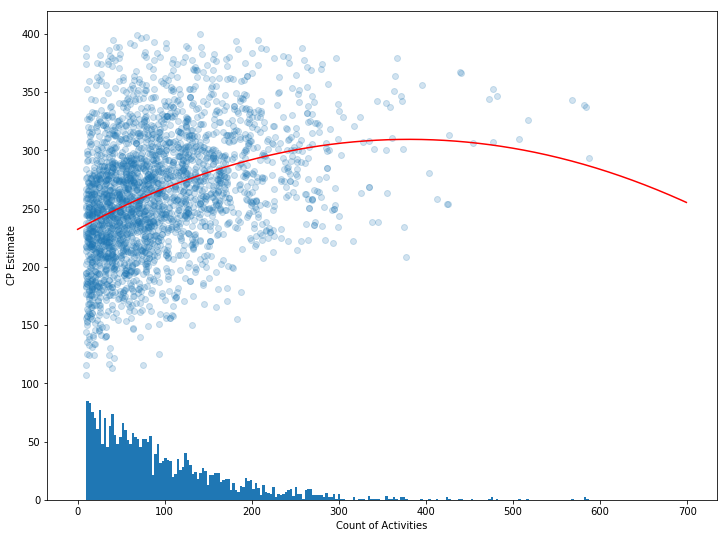

In [85]:
## correlation between cp and number of workouts
plot = plt.subplot()
z=plot.hist(full_athlete_years['count'], 200)
#plot.set_xscale('log')
#plot.grid(axis='y')
plt.xlabel('Count of Activities')
plt.ylabel('CP Estimate')
z=plot.scatter(full_athlete_years['count'], full_athlete_years['cp'], alpha=0.2)

fit=numpy.polyfit(full_athlete_years['count'], full_athlete_years['cp'], 2)
line = numpy.poly1d(fit)
x=range(0,700)
plot.plot(x, line(x), 'm-',c='red')

In [86]:
full_athlete_years['cp'].quantile([0.10,0.5,0.90,0.99])

0.10    195.186890
0.50    262.175525
0.90    331.548448
0.99    382.769652
Name: cp, dtype: float64

In [87]:
#full_athlete_years.to_csv('fullathleteyears_mmp.csv', sep=',')

In [88]:
#full_athlete_years_wpk.to_csv('fullathleteyears_mmp_wpk.csv', sep=',')

In [89]:
full_athlete_years_wpk['ratio'] = full_athlete_years_wpk['3600']/full_athlete_years_wpk['1200']
full_athlete_years_wpk['ratio2'] = full_athlete_years_wpk['3600']/full_athlete_years_wpk['1800']
full_athlete_years_wpk['ratio3'] = full_athlete_years_wpk['2640']/full_athlete_years_wpk['1200']

2717


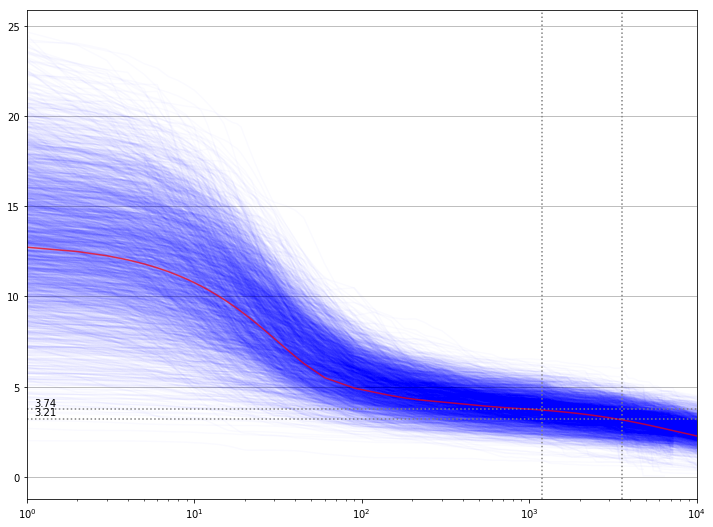

In [122]:
## lets look at all the curves

minr=0 # was interesting to filter based up 20:60 min power, this does all.

## overlay all the athlete seasons.
plot = plt.subplot()
plot.set_xscale('log') ## comment out if you don't want log-x scale
plot.grid(axis='y')
plt.xlim(1,10000) ## data beyond about 10000secs is not great

c=1
count=0
while (c < len(full_athlete_years_wpk)):

    ex=False
    ex=(c in full_athlete_years_wpk.index)
    ex=(ex and (full_athlete_years_wpk.loc[c][7]<25))
    ex=(ex and (full_athlete_years_wpk.loc[c]['ratio'] > minr))

    if ex != False:
        x = []
        y = []
        for idx in range(7,len(mmps.columns)-3):
            xv=float(full_athlete_years_wpk.columns.values[idx])
            yv=float(full_athlete_years_wpk.loc[c][idx])
            if ((math.isfinite(xv)) & (math.isfinite(yv))):
                x.append(xv)
                y.append(yv)

        z=plot.plot(x, y, 'b-',alpha=0.02)
        count=count+1
        
    c=c+1

# plot 50th percentile
##qs=full_athlete_years_wpk.loc[(full_athlete_years_wpk['1']<25)&(full_athlete_years_wpk['1']>10)].quantile([0.5])
qs=full_athlete_years_wpk.loc[full_athlete_years_wpk['ratio']>minr].quantile([0.5])
x = []
y = []
for idx in range(7,len(mmps.columns)-3):
    xv=float(full_athlete_years_wpk.columns.values[idx])
    yv=float(qs.iloc[0][idx])
    if ((math.isfinite(xv)) & (math.isfinite(yv))):
        x.append(xv)
        y.append(yv)

# bit of smoothing as x-axis is a but jumpy
s = splrep(x,y,s=2)
sy = splev(x,s)
z=plot.plot(x, sy, 'r-',alpha=0.7)

plot.axhline(qs.iloc[0]['1200'], linestyle=':', color='grey') # horizontal lines
plot.axvline(1200, linestyle=':', color='grey') # horizontal lines
plt.text(1.1,0.2+qs.iloc[0]['1200'],str(round(qs.iloc[0]['1200'],2)))

plot.axhline(qs.iloc[0]['3600'], linestyle=':', color='grey') # horizontal lines
plot.axvline(3600, linestyle=':', color='grey') # horizontal lines
plt.text(1.1,0.2+qs.iloc[0]['3600'],str(round(qs.iloc[0]['3600'],2)))
## and the basic info on who we just randomly plot
##full_athlete_years_wpk.loc[row]['id'],full_athlete_years_wpk.loc[row]['count']
print(count)

In [91]:
len(full_athlete_years_wpk), qs.iloc[0]['1200']*.86,qs.iloc[0]['1740']

(3221, 3.2170370370370374, 3.5428571428571427)

In [92]:
len(full_athlete_years_wpk[full_athlete_years_wpk['ratio']>0.95]), len(full_athlete_years_wpk)

(129, 3221)

In [93]:
len(full_athlete_years_wpk[full_athlete_years_wpk['1200']>4.5])

531

0    0.875
dtype: float64

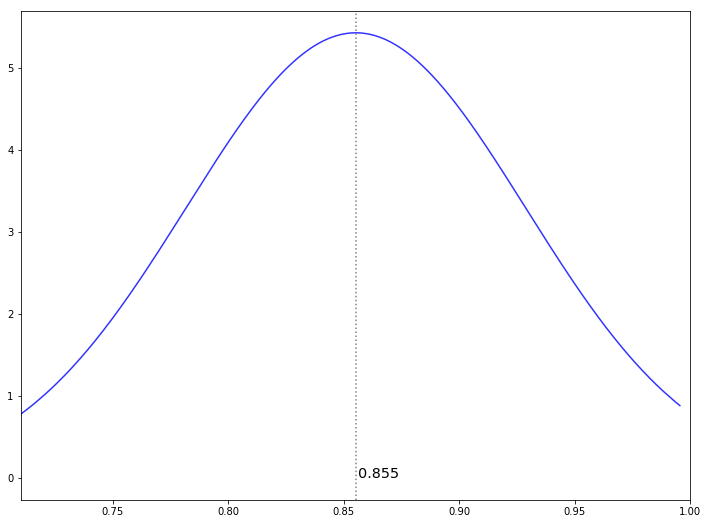

In [94]:
# distribution of 60:20 min power ratio
plot = plt.subplot()

data = full_athlete_years_wpk.loc[full_athlete_years_wpk['ratio']>0]['ratio']
h = data.sort_values()
pdf = norm.pdf(h, h.mean(), h.std())
plot.set_xlim(0.71,1.0)
#y, _, _ = plot.hist(h,100, color='blue', alpha=0.8)
factor=1# y.max()/pdf.max()
z=plot.plot(h, pdf*factor, color='blue', alpha=0.8)#

plot.axvline(h.mean(), linestyle=':', color='grey') # horizontal lines
plt.text(0.001+h.mean(),0, str(round(h.mean(),3)), size='x-large')
#
h.mode()

In [95]:
len(full_athlete_years_wpk.loc[full_athlete_years_wpk['1200']<=0])

0

In [96]:
##
## YoY CHANGES
##

# note this is looking at calendar years in the IR notebook we look at the continuum
# if impulse response using timeseries analysis 

In [97]:
## aggregate and calculate yoy changes

def calculate_year_to_year_increase(df, mmp_interval_columns):
    df = df.sort_values(by='year')
    df[mmp_interval_columns] = df[mmp_interval_columns].pct_change()
    return df

mmp_interval_columns = list(set([str(i) for i in range(1, 36000)]) & set(full_athlete_years.columns))
mmp_interval_columns.append('cp')
mmp_interval_columns.append('w')
mmp_interval_columns.append('pmax')
full_athlete_years_improvement = full_athlete_years.groupby('id').apply(calculate_year_to_year_increase, mmp_interval_columns)

In [98]:
full_athlete_years_improvement.head()

id  \
id                                                                             
000c6417-e1e4-497e-89e6-bb21e17ec355 0  000c6417-e1e4-497e-89e6-bb21e17ec355   
                                     1  000c6417-e1e4-497e-89e6-bb21e17ec355   
0031326c-e796-4f35-8f25-d3937edca90f 2  0031326c-e796-4f35-8f25-d3937edca90f   
                                     3  0031326c-e796-4f35-8f25-d3937edca90f   
004f16c9-6ec5-40ae-9ee0-d3b066e8a33b 6  004f16c9-6ec5-40ae-9ee0-d3b066e8a33b   

                                        year                     date  weight  \
id                                                                              
000c6417-e1e4-497e-89e6-bb21e17ec355 0  2017  2017/12/31 08:02:19 UTC    71.0   
                                     1  2018  2018/11/11 07:38:03 UTC    71.0   
0031326c-e796-4f35-8f25-d3937edca90f 2  2016  2016/12/31 07:44:41 UTC    81.0   
                                     3  2017  2017/12/31 20:11:44 UTC    81.0   
004f16c9-6ec5-40ae-9ee0-d3b066e8a33b 6  2018  2018/08/06 18:04:41 UTC    90.0   

                                         duration     distance  average_power  \
id                                                                              
000c6417-e1e4-497e-89e6-bb21e17ec355 0  1304560.0   9132.26161      278.05994   
                                     1  2117532.0  14837.33016      322.40127   
0031326c-e796-4f35-8f25-d3937edca90f 2    36409.0    196.08380      166.89544   
                                     3   389755.0   2039.55773      419.90909   
004f16c9-6ec5-40ae-9ee0-d3b066e8a33b 6   331301.0   1892.58005      267.38505   

                                               1         2         3  \
id                                                                     
000c6417-e1e4-497e-89e6-bb21e17ec355 0       NaN       NaN       NaN   
                                     1  0.053963  0.135036  0.121771   
0031326c-e796-4f35-8f25-d3937edca90f 2       NaN       NaN       NaN   
                                     3  0.567442  0.565495  0.630252   
004f16c9-6ec5-40ae-9ee0-d3b066e8a33b 6       NaN       NaN       NaN   

                                          ...     25200  28800  32400  36000  \
id                                        ...                                  
000c6417-e1e4-497e-89e6-bb21e17ec355 0    ...       NaN    NaN    NaN    NaN   
                                     1    ...       NaN    NaN    NaN    NaN   
0031326c-e796-4f35-8f25-d3937edca90f 2    ...       NaN    NaN    NaN    NaN   
                                     3    ...       NaN    NaN    NaN    NaN   
004f16c9-6ec5-40ae-9ee0-d3b066e8a33b 6    ...       NaN    NaN    NaN    NaN   

                                        Unnamed: 104  count        cp  \
id                                                                      
000c6417-e1e4-497e-89e6-bb21e17ec355 0           NaN    117       NaN   
                                     1           NaN    194  0.068578   
0031326c-e796-4f35-8f25-d3937edca90f 2           NaN     11       NaN   
                                     3           NaN    121  0.210522   
004f16c9-6ec5-40ae-9ee0-d3b066e8a33b 6           NaN     37       NaN   

                                               w      pmax   cpratio  
id                                                                    
000c6417-e1e4-497e-89e6-bb21e17ec355 0       NaN       NaN  0.997692  
                                     1 -0.099652  0.456568  0.951687  
0031326c-e796-4f35-8f25-d3937edca90f 2       NaN       NaN  0.974016  
                                     3  1.330799 -0.059643  1.013584  
004f16c9-6ec5-40ae-9ee0-d3b066e8a33b 6       NaN       NaN  0.971841  

[5 rows x 111 columns]

In [99]:
##full_athlete_years_improvement.to_csv("athleteyears_mmp_improvement.csv")

In [100]:
(full_athlete_years_improvement['cp']*100).quantile([0.99,0.95,0.9,0.8,0.75,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    56.011587
0.95    25.418890
0.90    16.653289
0.80     9.842176
0.75     8.009820
0.70     6.336183
0.60     3.490186
0.50     1.144374
0.40    -1.308189
0.30    -3.928771
0.20    -7.107997
0.10   -12.034037
Name: cp, dtype: float64

In [101]:
(full_athlete_years_improvement['w']*100).quantile([0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    227.274917
0.95    110.874613
0.90     71.175264
0.80     34.937601
0.70     20.365159
0.60      9.786785
0.50     -1.598316
0.40    -10.508127
0.30    -20.647358
0.20    -29.155937
0.10    -43.259376
Name: w, dtype: float64

In [102]:
(full_athlete_years_improvement['pmax']*100).quantile([0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    178.950830
0.95     85.574884
0.90     56.756492
0.80     31.897986
0.70     19.018962
0.60      9.957556
0.50      0.692556
0.40     -7.555816
0.30    -13.892613
0.20    -22.608991
0.10    -34.966423
Name: pmax, dtype: float64

1.4423076923076923


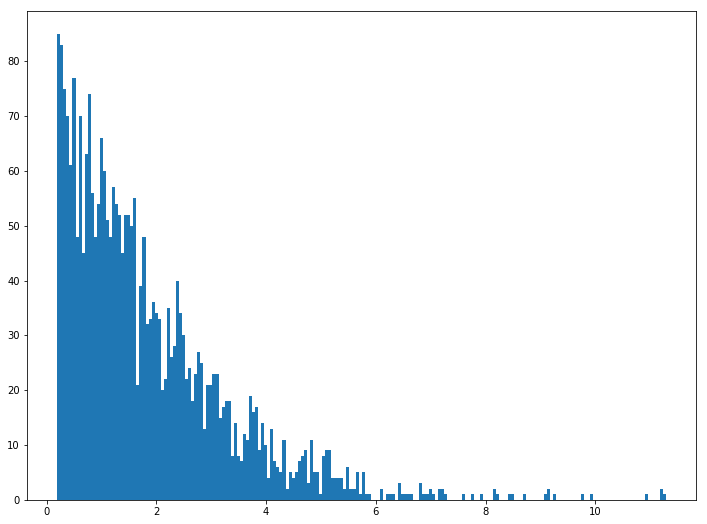

In [103]:
plot = plt.subplot()
z=plot.hist(full_athlete_years['count']/52, 200)
print(full_athlete_years['count'].median()/52)

/home/markl/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/markl/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


(2.244922859986691, 14.096104260078963)

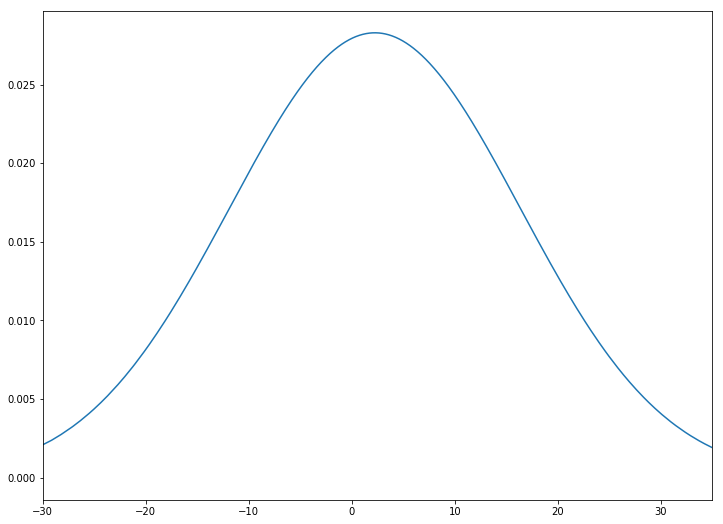

In [104]:
## range of improvements to cp YoY
data = full_athlete_years_improvement['cp']*100
h = data.sort_values()
pdf = norm.pdf(h, h.mean(), h.std())
plot = plt.subplot()
plot.set_xlim(-30,35)
z=plot.plot(h, pdf)
h.mean(), h.std()

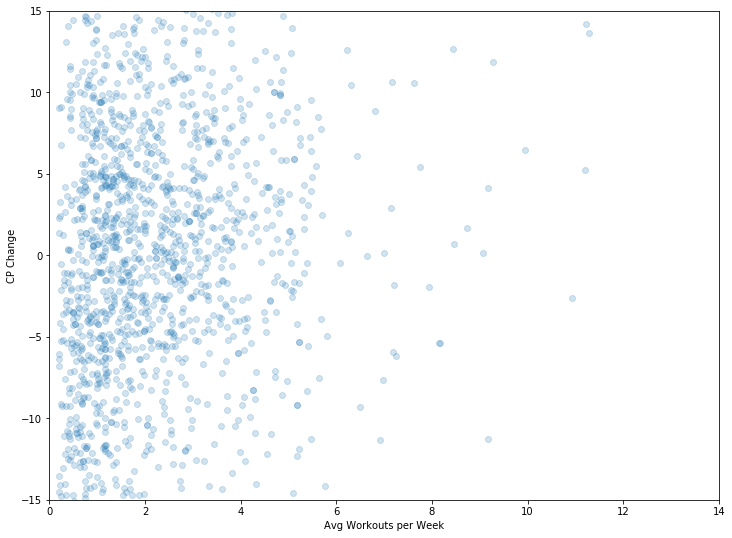

In [105]:
## relationship between workouts and change in cp YoY
plot = plt.subplot()
#plot.set_xscale('log')
#plot.grid(axis='y')
plt.xlabel('Avg Workouts per Week')
plt.ylabel('CP Change')
plt.ylim(-15,15)
plt.xlim(0,14)
z=plot.scatter(full_athlete_years_improvement['count']/52, full_athlete_years_improvement['cp']*100, alpha=0.2)

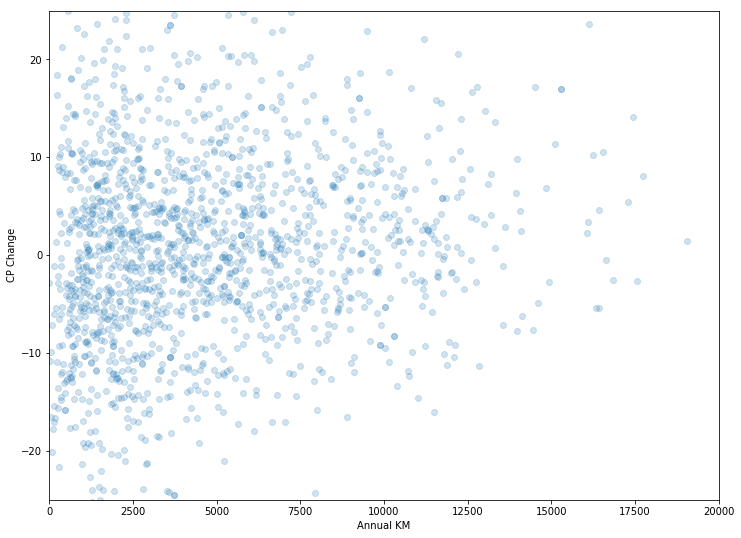

In [106]:
## distance and cp YoY
plot = plt.subplot()
#plot.set_xscale('log')
#plot.grid(axis='y')
plt.xlabel('Annual KM')
plt.ylabel('CP Change')
plt.ylim(-25,25)
plt.xlim(0,20000)
z=plot.scatter(full_athlete_years_improvement['distance'], full_athlete_years_improvement['cp']*100, alpha=0.2)

In [107]:
(full_athlete_years_improvement.loc[full_athlete_years_improvement['distance']>10000]['cp']*100).quantile([0.99,0.95,0.9,0.8,0.75,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    26.029307
0.95    17.178328
0.90    14.101676
0.80     8.639543
0.75     6.943049
0.70     6.077405
0.60     3.922588
0.50     2.484876
0.40     0.873863
0.30    -1.726746
0.20    -3.473101
0.10    -8.239632
Name: cp, dtype: float64

In [108]:
(full_athlete_years_improvement.loc[(full_athlete_years_improvement['distance']<10000)&(full_athlete_years_improvement['distance']>5000)]['cp']*100).quantile([0.99,0.95,0.9,0.8,0.75,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    39.467994
0.95    23.963958
0.90    16.071949
0.80    10.428927
0.75     8.638302
0.70     7.238600
0.60     4.305981
0.50     1.726142
0.40     0.124629
0.30    -2.458143
0.20    -4.682424
0.10    -8.544216
Name: cp, dtype: float64

In [109]:
(full_athlete_years_improvement.loc[(full_athlete_years_improvement['distance']<5000)&(full_athlete_years_improvement['distance']>2500)]['cp']*100).quantile([0.99,0.95,0.9,0.8,0.75,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    46.846874
0.95    23.542879
0.90    16.004030
0.80     8.669510
0.75     7.141139
0.70     4.888777
0.60     3.211408
0.50     0.830533
0.40    -1.320168
0.30    -3.712896
0.20    -7.215688
0.10   -11.978644
Name: cp, dtype: float64

In [110]:
(full_athlete_years_improvement.loc[full_athlete_years_improvement['distance']<2500]['cp']*100).quantile([0.99,0.95,0.9,0.8,0.75,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    66.577692
0.95    30.791309
0.90    18.648453
0.80    10.418701
0.75     8.426963
0.70     5.946233
0.60     2.756476
0.50    -0.424890
0.40    -3.578765
0.30    -6.301311
0.20   -10.278989
0.10   -14.830483
Name: cp, dtype: float64

In [111]:
(full_athlete_years_improvement.loc[full_athlete_years_improvement['count']/52<2]['cp']*100).quantile([0.99,0.95,0.9,0.8,0.75,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    63.185654
0.95    26.355224
0.90    17.264840
0.80     9.403843
0.75     7.471189
0.70     5.117968
0.60     2.427197
0.50    -0.202208
0.40    -3.011204
0.30    -5.568132
0.20    -9.128055
0.10   -14.200144
Name: cp, dtype: float64

In [112]:
(full_athlete_years_improvement.loc[(full_athlete_years_improvement['count']/52<4)&(full_athlete_years_improvement['count']/52>2)]['cp']*100).quantile([0.99,0.95,0.9,0.8,0.75,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    43.152652
0.95    24.732220
0.90    17.252324
0.80    10.491732
0.75     8.475790
0.70     7.134751
0.60     4.093844
0.50     2.081467
0.40     0.170402
0.30    -1.777312
0.20    -4.633856
0.10    -9.740283
Name: cp, dtype: float64

In [113]:
(full_athlete_years_improvement.loc[(full_athlete_years_improvement['count']/52<6)&(full_athlete_years_improvement['count']/52>4)]['cp']*100).quantile([0.99,0.95,0.9,0.8,0.75,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    31.556575
0.95    17.187198
0.90    14.140185
0.80     9.201092
0.75     8.106457
0.70     6.741222
0.60     4.168757
0.50     2.519206
0.40     0.469692
0.30    -2.503491
0.20    -5.152440
0.10    -8.932566
Name: cp, dtype: float64

In [114]:
(full_athlete_years_improvement.loc[full_athlete_years_improvement['count']/52>6]['cp']*100).quantile([0.99,0.95,0.9,0.8,0.75,0.7,0.6,0.5,0.4,0.3,0.2,0.1])

0.99    28.574424
0.95    20.776055
0.90    16.983157
0.80    12.856040
0.75    12.045735
0.70    10.572516
0.60     6.226344
0.50     3.494625
0.40     0.490596
0.30    -0.875530
0.20    -5.366255
0.10    -7.816292
Name: cp, dtype: float64

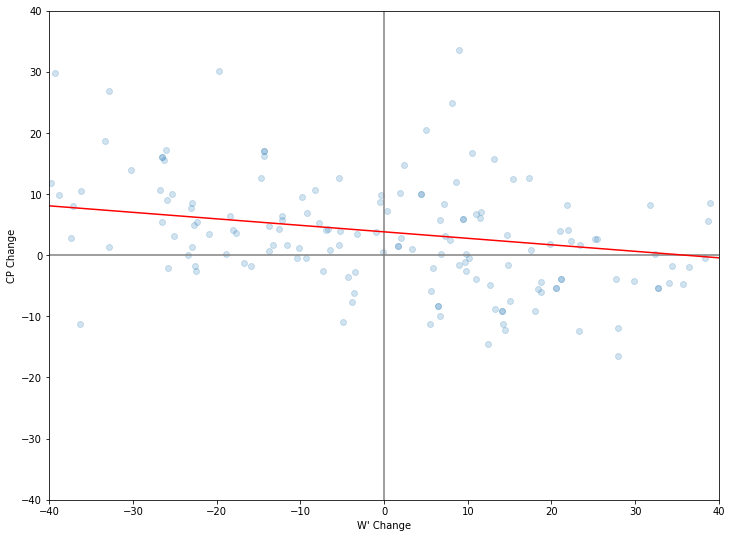

In [115]:
## relationship between change in w' and cp YoY
plot = plt.subplot()
#plot.set_xscale('log')
#plot.grid(axis='y')
plt.xlabel('W\' Change')
plt.ylabel('CP Change')
plt.ylim(-40,40)
plt.xlim(-40,40)
plot.axhline(0, linestyle='-', color='grey') # horizontal lines
plot.axvline(0, linestyle='-', color='grey') # vertical lines
nona=full_athlete_years_improvement.dropna(subset=['w','cp'])
x=nona.loc[nona['count']/52>4]['w']*100
y=nona.loc[nona['count']/52>4]['cp']*100
fit=linregress(x,y)
y1=fit.intercept+(-100*fit.slope)
x1=-100
y2=fit.intercept+(100*fit.slope)
x2=100
fx=[x1,x2]
fy=[y1,y2]
plot.plot(fx,fy,'-r')
z=plot.scatter(x,y, alpha=0.2)

In [116]:
print(fit)

LinregressResult(slope=-0.10621846314658773, intercept=3.8190694934239113, rvalue=-0.47150264808624626, pvalue=2.3615061184289353e-12, stderr=0.014190241063843125)
